In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.layers import Dense,Flatten,Dropout,GlobalAveragePooling2D,Conv2D

Using TensorFlow backend.


In [2]:
train_datagen = ImageDataGenerator(rescale = 1/255,shear_range = 0.2, zoom_range = 0.2,horizontal_flip = True, validation_split = 0.2)
path = r'.\data\Train_cartoon'
train_generator = train_datagen.flow_from_directory(path,target_size=(150, 150),subset = 'training')
validation_generator = train_datagen.flow_from_directory(path,target_size=(150, 150),subset = 'validation')

Found 3170 images belonging to 6 classes.
Found 789 images belonging to 6 classes.


In [3]:
pre_trained = InceptionV3(
    include_top = False,
    weights = None,
    input_tensor = None,
    input_shape=(150,150,3)
)

weight_path = 'inception_weights.h5'
pre_trained.load_weights(weight_path)

for layer in pre_trained.layers:
    layer.trainable = False
    
pre_trained.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [31]:
last_layer = pre_trained.get_layer('mixed10')
last_output = last_layer.output

y = Conv2D(1024, kernel_size = 1, activation = 'relu')(last_output)
y = GlobalAveragePooling2D()(y)
y = Dropout(0.4)(y)
y = Dense(512,activation = 'relu')(y)
y = Dropout(0.4)(y)
y = Dense(6,activation = 'softmax')(y)
from keras.models import Model

model = Model(pre_trained.input,y)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [32]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam

def schedule(epoch, lr):
    if epoch > 30:
        return 0.00001
    elif epoch > 20:
        return 0.00005
    elif epoch>15:
        return 0.0001
    elif epoch > 10:
        return 0.0005
    else:
        return 0.001

adam = Adam(lr = 0.001)
early_stopping_cb = EarlyStopping(patience = 20)
checkpoint_cb = ModelCheckpoint('model4.h5', save_best_only = True)
learn_rate_scheduler = LearningRateScheduler(schedule)
model.compile(loss = 'categorical_crossentropy',optimizer = adam, metrics = ['accuracy'])

In [33]:
history = model.fit(train_generator,validation_data = validation_generator ,epochs = 100, callbacks = [checkpoint_cb,early_stopping_cb,learn_rate_scheduler])

Epoch 1/100
100/100 [==============================] - 48s 480ms/step - loss: 1.6935 - accuracy: 0.3521 - val_loss: 2.4003 - val_accuracy: 0.3587
Epoch 2/100
100/100 [==============================] - 41s 408ms/step - loss: 1.2993 - accuracy: 0.5252 - val_loss: 2.1377 - val_accuracy: 0.3967
Epoch 3/100
100/100 [==============================] - 41s 413ms/step - loss: 1.0846 - accuracy: 0.6192 - val_loss: 2.2166 - val_accuracy: 0.4664
Epoch 4/100
100/100 [==============================] - 41s 414ms/step - loss: 1.0631 - accuracy: 0.6252 - val_loss: 1.6408 - val_accuracy: 0.4119
Epoch 5/100
100/100 [==============================] - 42s 417ms/step - loss: 0.9916 - accuracy: 0.6580 - val_loss: 2.5243 - val_accuracy: 0.4994
Epoch 6/100
100/100 [==============================] - 42s 416ms/step - loss: 0.8889 - accuracy: 0.6883 - val_loss: 2.9647 - val_accuracy: 0.4284
Epoch 7/100
100/100 [==============================] - 42s 418ms/step - loss: 0.8653 - accuracy: 0.6994 - val_loss: 1.5895 -

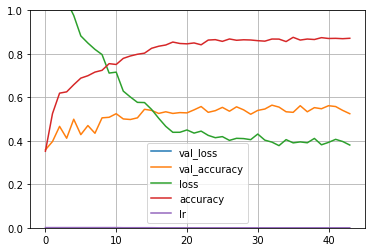

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
def plot_training_accuracy(history):
    pd.DataFrame(history.history).plot()
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_training_accuracy(history)

In [35]:
test_gen = ImageDataGenerator(rescale = 1/255)
path = r'.\data\Test_cartoon'
test_generator = test_gen.flow_from_directory(path,target_size=(150, 150))

Found 1199 images belonging to 6 classes.


In [36]:
model.evaluate(test_generator)

38/38 [==============================] - 5s 129ms/step


[3.1756551265716553, 0.5688073635101318]